In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import random
import time
from pyomo.environ import *
from pyomo.opt import SolverFactory
import matplotlib.pyplot as plt
import gym
from gym import spaces, logger
from random import choice
from mlxtend.preprocessing import one_hot
import scipy.stats as stats
import math

In [2]:
class make_network(gym.Env):

    def __init__(self):

        # read technical parameters of distribution network from input excel
        self.network_data = pd.read_excel('topology.template 42M.xlsx', sheet_name=None)
        
        # bus name and voltage limits
        self.Bus_name = self.network_data['BUSES']['NAME'].values
        self.Bus_v = self.network_data['BUSES']['U'].values
        self.Bus_min_v = self.network_data['BUSES']['UMIN'].values
        self.Bus_max_v = self.network_data['BUSES']['UMAX'].values
        
        # line name, topology, reactance, resistance, current limit
        self.Line_name = self.network_data['LINES']['NAME'].values
        self.Line_from = self.network_data['LINES']['BUS1'].values
        self.Line_to = self.network_data['LINES']['BUS2'].values
        self.Line_x = self.network_data['LINES']['X'].values
        self.Line_r = self.network_data['LINES']['R'].values
        self.Line_max_i = self.network_data['LINES']['CURRENTLIMIT'].values
        
        # transformer name, topology, reactance, resistance
        self.Transformer_name = self.network_data['TRANSFORMERS']['NAME'].values
        self.Transformer_from = self.network_data['TRANSFORMERS']['BUS1'].values
        self.Transformer_to = self.network_data['TRANSFORMERS']['BUS2'].values
        self.Transformer_x = self.network_data['TRANSFORMERS']['X'].values
        self.Transformer_r = self.network_data['TRANSFORMERS']['R'].values
        
        # load name, topology, active and reactive power, shedding cost
        self.Load_name = self.network_data['LOADS']['NAME'].values
        self.Load_bus = self.network_data['LOADS']['BUS'].values
        self.Load_p_base = self.network_data['LOADS']['P'].values * 1000
        self.Load_q_base = self.network_data['LOADS']['Q'].values * 1000
        self.Load_cost = self.network_data['LOADS']['LAMBDA'].values
        self.demand_profile = pd.read_excel('Demand_Profile.xlsx', 'Demand_Profile').values[:,0]
        self.Load_p = np.array([[x*y for x in self.demand_profile] for y in self.Load_p_base])
        
        # generator name, topology, active power capacity, reactive power capacity
        self.DG_name = self.network_data['GENERATORS']['NAME'].values
        self.DG_bus = self.network_data['GENERATORS']['BUS'].values
        self.DG_min_p = self.network_data['GENERATORS']['MINP'].values * 1000
        self.DG_max_p = self.network_data['GENERATORS']['MAXP'].values * 1000
        self.DG_min_q = self.network_data['GENERATORS']['MINQ'].values * 1000
        self.DG_max_q = self.network_data['GENERATORS']['MAXQ'].values * 1000
        
        # switch name, topology, status
        self.Switch_name = self.network_data['SWITCHES']['NAME'].values
        self.Switch_from = self.network_data['SWITCHES']['BUS1'].values
        self.Switch_to = self.network_data['SWITCHES']['BUS2'].values
        self.Switch_status = self.network_data['SWITCHES']['OPEN'].values
        
        # mobile source data
        self.mobile_data = pd.read_excel('MPS_data.xlsx', sheet_name=None)
        # meg location, capacity
        self.meg_bus = self.mobile_data['meg_position'].values[:,-24:]
        self.meg_max_p = self.mobile_data['meg_parameters']['MEG_P'].values
        # meg location, capacity
        self.mess_bus = self.mobile_data['mess_position'].values[:,-24:]
        self.mess_max_p = self.mobile_data['mess_parameters']['MESS_P'].values
        self.mess_max_e = self.mobile_data['mess_parameters']['MESS_E'].values
        self.mess_e0 = self.mobile_data['mess_parameters']['MESS_0'].values
        self.mess_f = self.mobile_data['mess_parameters']['MESS_F'].values
        # meg location, capacity
        self.rc_bus = self.mobile_data['rc_position'].values[:,-24:]
        
        # number of bus, line, transformer, load, generator
        self.n_bus = self.network_data['BUSES'].shape[0]
        self.n_line = self.network_data['LINES'].shape[0] 
        self.n_transformer = self.network_data['TRANSFORMERS'].shape[0] 
        self.n_load = self.network_data['LOADS'].shape[0]
        self.n_dg = self.network_data['GENERATORS'].shape[0]
        self.n_switch = self.network_data['SWITCHES'].shape[0]
        self.n_time = 24
        self.n_meg = len(self.meg_max_p)
        self.n_mess = len(self.mess_max_p)
        
        
    def ACOPF_model(self):
        
        # construct optimisation model
        model = ConcreteModel('ACOPF')
        
        # Define sets
        model.T = Set(initialize=[t for t in range(self.n_time)], doc='Hours', ordered=True)
        model.B = Set(initialize=[b for b in range(self.n_bus)], doc='Buses', ordered=True)
        model.L = Set(initialize=[l for l in range(self.n_line)], doc='Lines', ordered=True)
        model.F = Set(initialize=[f for f in range(self.n_transformer)], doc='Transformers', ordered=True)
        model.D = Set(initialize=[d for d in range(self.n_load)], doc='Loads', ordered=True)
        model.G = Set(initialize=[g for g in range(self.n_dg)], doc='Generators', ordered=True)
        model.S = Set(initialize=[s for s in range(self.n_switch)], doc='Switches', ordered=True)
        model.MEG = Set(initialize=[g for g in range(self.n_meg)], doc='MEGs', ordered=True)
        model.MESS = Set(initialize=[s for s in range(self.n_mess)], doc='MESSs', ordered=True)

        # Define variables
        model.dg_p = Var(model.G, model.T, domain=Reals) # generator active power
        model.loadshed_p = Var(model.D, model.T, domain=NonNegativeReals) # active load shedding
        model.las = Var(model.L, model.T, domain=Reals) # line active power flow sending
        model.lar = Var(model.L, model.T, domain=Reals) # line active power flow receiving
        model.lrs = Var(model.L, model.T, domain=Reals) # line reactive power flow sending
        model.lrr = Var(model.L, model.T, domain=Reals) # line reactive power flow receiving
        model.fas = Var(model.F, model.T, domain=Reals) # transformer active power flow sending
        model.far = Var(model.F, model.T, domain=Reals) # transformer active power flow receiving
        model.frs = Var(model.F, model.T, domain=Reals) # transformer reactive power flow sending
        model.frr = Var(model.F, model.T, domain=Reals) # transformer reactive power flow receiving
        model.sas = Var(model.S, model.T, domain=Reals) # switch active power flow sending
        model.sar = Var(model.S, model.T, domain=Reals) # switch active power flow receiving
        model.srs = Var(model.S, model.T, domain=Reals) # switch eactive power flow sending
        model.srr = Var(model.S, model.T, domain=Reals) # switch reactive power flow receiving
        model.volt = Var(model.B, model.T, domain=NonNegativeReals) # bus voltage**2
        model.lcurrent = Var(model.L, model.T, domain=NonNegativeReals) # line current**2
        model.fcurrent = Var(model.F, model.T, domain=NonNegativeReals) # transformer current**2
        model.meg_p = Var(model.MEG, model.T, domain=NonNegativeReals) 
        model.mess_c = Var(model.MESS, model.T, domain=NonNegativeReals)
        model.mess_d = Var(model.MESS, model.T, domain=NonNegativeReals)
        model.mess_e = Var(model.MESS, model.T, domain=NonNegativeReals)
        model.mess_v = Var(model.MESS, model.T, domain=Binary)

        # generator operating constraints
        def _dg_p_UB_stay(model, g, t):
            return model.dg_p[g,t] <= self.DG_max_p[g]
        model.dg_p_UB_stay = Constraint(model.G, model.T, rule=_dg_p_UB_stay)

        def _dg_p_LB_stay(model, g, t):
            return model.dg_p[g,t] >= self.DG_min_p[g]
        model.dg_p_LB_stay = Constraint(model.G, model.T, rule=_dg_p_LB_stay)

        # load shedding constraint
        def _loadshed_p_UB_(model, d, t):
            return model.loadshed_p[d,t] <= self.Load_p[d,t]
        model.loadshed_p_UB_ = Constraint(model.D, model.T, rule=_loadshed_p_UB_)
        
        # meg operating constraints
        def _meg_p_UB_stay(model, g, t):
            return model.meg_p[g,t] <= self.meg_max_p[g]
        model.meg_p_UB_stay = Constraint(model.MEG, model.T, rule=_meg_p_UB_stay)
        
        # mess charge constraints
        def _mess_c_UB_stay(model, s, t):
            return model.mess_c[s,t] <= self.mess_max_p[s] * model.mess_v[s,t]
        model.mess_c_UB_stay = Constraint(model.MESS, model.T, rule=_mess_c_UB_stay)
        
        # mess discharge constraints
        def _mess_d_UB_stay(model, s, t):
            return model.mess_d[s,t] <= self.mess_max_p[s] * (1-model.mess_v[s,t])
        model.mess_d_UB_stay = Constraint(model.MESS, model.T, rule=_mess_d_UB_stay)
        
        # mess soc constraints
        def _mess_e_UB_stay(model, s, t):
            return model.mess_e[s,t] <= self.mess_max_e[s] 
        model.mess_e_UB_stay = Constraint(model.MESS, model.T, rule=_mess_e_UB_stay)

        # mess soc equation    
        def _mess_e_BAL_stay(model, s, t):
            if t == 0:
                return model.mess_e[s,t] == self.mess_e0[s] + model.mess_c[s,t]*self.mess_f[s] - model.mess_d[s,t]/self.mess_f[s]
            else:
                return model.mess_e[s,t] == model.mess_e[s,t-1] + model.mess_c[s,t]*self.mess_f[s] - model.mess_d[s,t]/self.mess_f[s]  
        model.mess_e_BAL_stay = Constraint(model.MESS, model.T, rule=_mess_e_BAL_stay)  

        # nodal active power balance
        def _node_balance_active_(model, b, t): 
            return + sum(model.dg_p[g,t] for g in model.G if self.DG_bus[g] == self.Bus_name[b]) \
                   + sum(model.meg_p[g,t] for g in model.MEG if self.meg_bus[g,t] == self.Bus_name[b]) \
                   + sum(model.mess_d[s,t] for s in model.MESS if self.mess_bus[s,t] == self.Bus_name[b]) \
                   - sum(model.mess_c[s,t] for s in model.MESS if self.mess_bus[s,t] == self.Bus_name[b]) \
                   - sum(self.Load_p[d,t] for d in model.D if self.Load_bus[d] == self.Bus_name[b]) \
                   + sum(model.loadshed_p[d,t] for d in model.D if self.Load_bus[d] == self.Bus_name[b]) == \
                   + sum(model.las[l,t] for l in model.L if self.Line_from[l] == self.Bus_name[b]) \
                   + sum(model.lar[l,t] for l in model.L if self.Line_to[l] == self.Bus_name[b]) \
                   + sum(model.fas[f,t] for f in model.F if self.Transformer_from[f] == self.Bus_name[b]) \
                   + sum(model.far[f,t] for f in model.F if self.Transformer_to[f] == self.Bus_name[b]) \
                   + sum(model.sas[s,t] for s in model.S if self.Switch_from[s] == self.Bus_name[b]) \
                   + sum(model.sar[s,t] for s in model.S if self.Switch_to[s] == self.Bus_name[b])
        model.NodeBalanceActive_ = Constraint(model.B, model.T, rule=_node_balance_active_)

        # nodal voltage constraints
        def _volt_UB_(model, b, t):
            return model.volt[b,t] <= self.Bus_max_v[b]**2
        model.volt_UB_ = Constraint(model.B, model.T, rule=_volt_UB_)
        
        def _volt_LB_(model, b ,t):
            return model.volt[b,t] >= self.Bus_min_v[b]**2
        model.volt_LB_ = Constraint(model.B, model.T, rule=_volt_LB_)
        
        #---------------------- line constraints ----------------------#
        # line current constraints
        def _line_current_UB_(model, l, t):
            return model.lcurrent[l,t] <= self.Line_max_i[l]**2
        model.line_current_UB_ = Constraint(model.L, model.T, rule=_line_current_UB_)
        
        # second order cone distflow
        def _line_equal_1(model, l, t):
            return model.las[l,t] == - model.lar[l,t]
        model.line_equal_1 = Constraint(model.L, model.T, rule=_line_equal_1)

        def _line_equal_2(model, l, t):
            return model.lrs[l,t] == - model.lrr[l,t]
        model.line_equal_2 = Constraint(model.L, model.T, rule=_line_equal_2)
        
        # line power flow constraints 
        def _line_flow_send_UB_(model, l, t):
            return model.lar[l,t] * model.lar[l,t] + model.lrr[l,t] * model.lrr[l,t] <= \
                   sum(model.lcurrent[l,t] * model.volt[b,t] for b in model.B if self.Line_from[l] == self.Bus_name[b])
        model.line_flow_send_UB_ = Constraint(model.L, model.T, rule=_line_flow_send_UB_)
        
        # linearized distflow
        def line_flow_(model, l, t):
            return (sum(model.volt[b,t] for b in model.B if self.Bus_name[b] == self.Line_from[l]) - \
                    sum(model.volt[b,t] for b in model.B if self.Bus_name[b] == self.Line_to[l])) == \
                    2 * (self.Line_r[l] * model.las[l,t] + self.Line_x[l] * model.lrs[l,t])
        model.LinePhaseActiveFlow = Constraint(model.L, model.T, rule=line_flow_)
        
        #---------------------- transformer constraints ----------------------#
        def _transformer_equal_1(model, f, t):
            return model.fas[f,t] == - model.far[f,t]
        model.transformer_equal_1 = Constraint(model.F, model.T, rule=_transformer_equal_1)

        def _transformer_equal_2(model, f, t):
            return model.frs[f,t] == - model.frr[f,t]
        model.transformer_equal_2 = Constraint(model.F, model.T, rule=_transformer_equal_2)
        
        # linearized distflow
#         def transformer_flow_(model, f, t):
#             return (sum(model.volt[b,t] for b in model.B if self.Bus_name[b] == self.Transformer_from[f]) - \
#                     sum(model.volt[b,t] for b in model.B if self.Bus_name[b] == self.Transformer_to[f])) >= \
#                     2 * (self.Transformer_r[f] * model.fas[f,t] + self.Transformer_x[f] * model.frs[f,t])
#         model.TransformerPhaseActiveFlow = Constraint(model.F, model.T, rule=transformer_flow_)
        
        #---------------------- switch constraints ----------------------#
        def _switch_equal_1(model, s, t):
            return model.sas[s,t] == - model.sar[s,t]
        model.switch_equal_1 = Constraint(model.S, model.T, rule=_switch_equal_1)

        def _switch_equal_2(model, s, t):
            return model.srs[s,t] == - model.srr[s,t]
        model.switch_equal_2 = Constraint(model.S, model.T, rule=_switch_equal_2)
        
        def _switch_status_connect_(model, s, t):
            if self.Switch_status[s] == 'OPEN':
                return model.sas[s,t] == 0   
            return Constraint.Skip
        model.switch_status_connect_ = Constraint(model.S, model.T, rule=_switch_status_connect_)
        
        # --------------- outage scenario -----------------    
        damage = self.rc_bus
        def _outage_status_connect_(model, l, t):
            for i in range(len(damage)):
                if l == damage[i,t]:
                    return model.lcurrent[l,t] == 0
            return Constraint.Skip
        model.outage_status_connect_ = Constraint(model.L, model.T, rule=_outage_status_connect_)
        
        # -------------- objective function --------------      
        def _obj_(model):
            return sum(self.Load_cost[d] * model.loadshed_p[d,t] for d in model.D for t in model.T)
        model.objective = Objective(rule=_obj_, sense=minimize)

        return model

In [3]:
Network = make_network()
inst = Network.ACOPF_model()
solver = SolverFactory ('gurobi', tee=True)
result = solver.solve (inst, tee=True)
print(value(inst.objective))

C:\Users\Dawei Qiu\anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-16
Read LP format model from file C:\Users\DAWEIQ~1\AppData\Local\Temp\tmpb2vrti72.pyomo.lp
Reading time = 0.06 seconds
x19417: 22548 rows, 19249 columns, 41093 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 22548 rows, 19249 columns and 41093 nonzeros
Model fingerprint: 0xc7fec7f2
Model has 2616 quadratic constraints
Variable types: 19177 continuous, 72 integer (72 binary)
Coefficient statistics:
  Matrix range     [2e-03, 5e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 2e+05]
Presolve removed 20417 rows and 13754 columns
Presolve time: 1.48s
Presolved: 2131 rows, 5495 columns, 7615 nonzeros
Presolved model has 

In [4]:
Load_SP = np.zeros([Network.n_load,Network.n_time])
Load_P = np.zeros([Network.n_load,Network.n_time])
DG_P = np.zeros([Network.n_dg,Network.n_time])
MEG_P = np.zeros([Network.n_meg,Network.n_time])
MESS_C = np.zeros([Network.n_mess,Network.n_time])
MESS_D = np.zeros([Network.n_mess,Network.n_time])
LineFlow_P = np.zeros([Network.n_line,Network.n_time])
LineCurrent = np.zeros([Network.n_line,Network.n_time])
SwitchFlow_P = np.zeros([Network.n_switch,Network.n_time])
BusVoltage = np.zeros([Network.n_bus,Network.n_time])
for t in inst.T:
    for d in inst.D:
        Load_SP[d,t] = value(inst.loadshed_p[d,t])
        Load_P[d,t] = Network.Load_p[d,t] - Load_SP[d,t]
    for g in inst.G:
        DG_P[g,t] = value(inst.dg_p[g,t])
    for g in inst.MEG:
        MEG_P[g,t] = value(inst.meg_p[g,t])
    for s in inst.MESS:
        MESS_C[s,t] = value(inst.mess_c[s,t])
        MESS_D[s,t] = value(inst.mess_d[s,t])
    for l in inst.L:
        LineFlow_P[l,t] = value(inst.las[l,t])
        LineCurrent[l,t] = value(inst.lcurrent[l,t])**0.5
    for s in inst.S:
        SwitchFlow_P[s,t] = value(inst.sas[s,t])
    for b in inst.B:
        BusVoltage[b,t] = value(inst.volt[b,t])**0.5

In [5]:
Left_DG, Right_DG = [], []
for g in range(Network.n_dg):
    if g == 0:
        GGrid = DG_P[g]
    elif g == 10 or g == 11:  
        Left_DG.append(DG_P[g])
    else:
        Right_DG.append(DG_P[g])
        
GGrid_Buy, GGrid_Sell = np.zeros(24), np.zeros(24) 
for t in range(24):
    if GGrid[t] >= 0:
        GGrid_Buy[t] = GGrid[t]
    else:
        GGrid_Sell[t] = -GGrid[t]

Left_Load_Base, Left_Load_Net, Left_Load_Shed = [], [], [] 
Right_Load_Base, Right_Load_Net, Right_Load_Shed = [], [], []
for d in range(len(Network.Load_p)):
    if d <= 12:
        Right_Load_Base.append(Network.Load_p[d])
        Right_Load_Net.append(Load_P[d])
        Right_Load_Shed.append(Load_SP[d])
    else:
        Left_Load_Base.append(Network.Load_p[d])
        Left_Load_Net.append(Load_P[d])
        Left_Load_Shed.append(Load_SP[d]) 
        
Left_EssLoad_Base, Right_EssLoad_Base = [], []
for d in range(len(Network.Load_p)):
    if d <= 12 and Network.Load_cost[d] == 10:
        Right_EssLoad_Base.append(Network.Load_p[d])
    if d >= 13 and Network.Load_cost[d] == 10:
        Left_EssLoad_Base.append(Network.Load_p[d])
        
Left_Load_Base_Sum = np.sum(Left_Load_Base, axis=0)
Left_EssLoad_Base_Sum = np.sum(Left_EssLoad_Base, axis=0)
Left_Load_Shed_Sum = np.sum(Left_Load_Shed, axis=0)
Left_DG_Sum = np.sum(Left_DG, axis=0)

Right_Load_Base_Sum = np.sum(Right_Load_Base, axis=0)
Right_EssLoad_Base_Sum = np.sum(Right_EssLoad_Base, axis=0)
Right_Load_Shed_Sum = np.sum(Right_Load_Shed, axis=0)
Right_DG_Sum = np.sum(Right_DG, axis=0)

MEG_P_Sum = np.sum(MEG_P, axis=0)
MESS_C_Sum = np.sum(MESS_C, axis=0)
MESS_D_Sum = np.sum(MESS_D, axis=0)

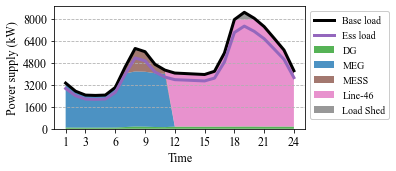

In [6]:
plt.figure(figsize = (4.5,2.25))
sources = ['DG', 'MEG', 'MESS', 'Line-46', 'Load Shed']
colors = ['tab:green', 'tab:blue', 'tab:brown', 'tab:pink', 'tab:gray']
x = range(24)
line_width = 3
alpha=0.8
space = 0.5
text1 = 10
text2 = 12
font1 = {'family': 'Times New Roman', 'weight': 'normal', 'size': text1}
font2 = {'family': 'Times New Roman', 'weight': 'normal', 'size': text2}
plt.plot(x, Left_Load_Base_Sum, '-', color='black', label='Base load', linewidth=line_width)
plt.plot(x, Left_EssLoad_Base_Sum, '-', color='tab:purple', label='Ess load', linewidth=line_width)
stacks = plt.stackplot(x, Left_DG_Sum, MEG_P_Sum, MESS_D_Sum, LineFlow_P[45], Left_Load_Shed_Sum, 
                       labels=sources, colors=colors, alpha=alpha)
plt.grid(which='major', linestyle='--', axis='y')
plt.tick_params(labelsize = text2)
plt.xticks(np.linspace(0,23), fontname = "Times New Roman")
plt.xticks([0,2,5,8,11,14,17,20,23],['1','3','6','9','12','15','18','21','24'])
plt.yticks(np.linspace(0,8000,6), fontname = "Times New Roman")
plt.ylabel('Power supply (kW)', font2)
plt.xlabel('Time', font2)
legend = plt.legend(loc='upper left', prop=font1, labelspacing=space, framealpha=1, ncol=1, bbox_to_anchor=(1,1))
plt.savefig('Day_LineOutage_Mobile_Left.jpg', bbox_inches='tight', dpi = 900)
plt.show()

In [7]:
NonEss_Load_Base, NonEss_Load_Net, NonEss_Load_Shed = [], [], []
Ess_Load_Base, Ess_Load_Net, Ess_Load_Shed = [], [], []
for d in range(len(Network.Load_p)):
    if Network.Load_cost[d] == 10:
        Ess_Load_Base.append(Network.Load_p[d])
        Ess_Load_Net.append(Load_P[d])
        Ess_Load_Shed.append(Load_SP[d])
    else:
        NonEss_Load_Base.append(Network.Load_p[d])
        NonEss_Load_Net.append(Load_P[d])
        NonEss_Load_Shed.append(Load_SP[d])
        
Ess_Load_Base_Sum = np.sum(Ess_Load_Base, axis=0)
Ess_Load_Net_Sum = np.sum(Ess_Load_Net, axis=0)
Ess_Load_Shed_Sum = np.sum(Ess_Load_Shed, axis=0)
NonEss_Load_Base_Sum = np.sum(NonEss_Load_Base, axis=0)
NonEss_Load_Net_Sum = np.sum(NonEss_Load_Net, axis=0)
NonEss_Load_Shed_Sum = np.sum(NonEss_Load_Shed, axis=0)
Load_Base_Sum = np.sum(Network.Load_p, axis=0)
Load_Net_Sum = np.sum(Load_P, axis=0)
Load_Shed_Sum = np.sum(Load_SP, axis=0)

GGrid, G8, G11, G17, G24, G26 = DG_P[0], np.sum([DG_P[1], DG_P[2]], axis=0), DG_P[3], DG_P[4], DG_P[5], DG_P[6]
G33, G34, G22, G88, G119, G120 = DG_P[7], DG_P[8], DG_P[9], np.sum([DG_P[10], DG_P[11]], axis=0), DG_P[12], DG_P[13]
G126, G128, G130, G133, G132, G122, G124 = DG_P[14], DG_P[15], DG_P[16], DG_P[17], DG_P[18], DG_P[19], DG_P[20]
DG_Sum = np.sum([G8, G11, G17, G24, G26, G33, G34, G22, G88, G119, G120, G126, G128, G130, G133, G132, G122, G124], axis=0)

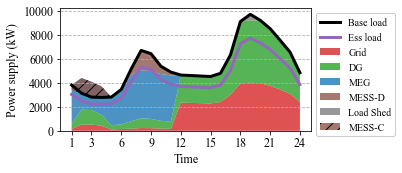

In [8]:
plt.figure(figsize = (4.5,2.25))
sources = ['Grid', 'DG', 'MEG', 'MESS-D', 'Load Shed', 'MESS-C']
colors = ['tab:red', 'tab:green', 'tab:blue', 'tab:brown', 'tab:gray', 'tab:brown']
x = range(24)
line_width = 3
alpha=0.8
space = 0.5
text1 = 10
text2 = 12
font1 = {'family': 'Times New Roman', 'weight': 'normal', 'size': text1}
font2 = {'family': 'Times New Roman', 'weight': 'normal', 'size': text2}
plt.plot(x, Load_Base_Sum, '-', color='black', label='Base load', linewidth=line_width)
plt.plot(x, Ess_Load_Base_Sum, '-', color='tab:purple', label='Ess load', linewidth=line_width)
stacks = plt.stackplot(x, GGrid_Buy, DG_Sum, MEG_P_Sum, MESS_D_Sum, Load_Shed_Sum, -MESS_C_Sum,
                       labels=sources, colors=colors, alpha=alpha)
plt.grid(which='major', linestyle='--', axis='y')
plt.tick_params(labelsize = text2)
plt.xticks(np.linspace(0,23), fontname = "Times New Roman")
plt.xticks([0,2,5,8,11,14,17,20,23],['1','3','6','9','12','15','18','21','24'])
plt.yticks(np.linspace(0,10000,6), fontname = "Times New Roman")
plt.ylabel('Power supply (kW)', font2)
plt.xlabel('Time', font2)
hatches = ['','','','','','//']
for stack, hatch in zip(stacks, hatches):
    stack.set_hatch(hatch)
legend = plt.legend(loc='upper left', prop=font1, labelspacing=space, framealpha=1, ncol=1, bbox_to_anchor=(1,1))
plt.savefig('Day_LineOutage_Mobile.jpg', bbox_inches='tight', dpi = 900)
plt.show()

In [ ]:
MESS_D_Sum

In [ ]:
MESS_C_Sum

In [ ]:
MESS_C_Sum = np.array([ 0.        , 1127.80018534, 1137.08715416, 1137.83721157,
        840.27148519,  0,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.    ])